# RYVU recruitment task


Lead optimization is the phase in drug discovery where we want to optimise properties of the
molecule, so that it will meet all the requirements for being a drug. First of all, it cannot be toxic for
people. So one of the properties which is checked, is activity on hERG which may lead to
cardiotoxicity. In order to speed up lead optimization, machine learning models predicting properties
can be applied and this is exactly your task: build ML model predicting hERG. The assignment is a toy
problem that reflects small part of challenges that you might expect when working in Data Science
department at Ryvu Therapeutics..

Dataset coming from paper https://jcheminf.biomedcentral.com/articles/10.1186/s13321-021-00541-z
The training data used in this study can be found
at https://github.com/Abdulk084/CardioTox/blob/master/data/train_validation_cardio_tox_data.tar.xz.
* Test set-I: The positively biased test set can be found
at https://github.com/Abdulk084/CardioTox/blob/master/data/external_test_set_pos.csv.
* Test set-II: The negatively biased test set can be found
at https://github.com/Abdulk084/CardioTox/blob/master/data/external_test_set_neg.csv.
* Test set-III: Relatively larger negatively biased test set can be found
at https://github.com/Abdulk084/CardioTox/blob/master/data/external_test_set_new.csv

## Task 1

You first task is to build model in active learning fashion in Jupyter Notebook. You should:
* Prepare the data for modelling
* Choose data representation
* Build starting model
* Decide upon active learning strategy and apply it to improve your model
* Decide when to stop labelling new data in lab as labelling compounds via lab experiments is
always additional cost

## Task 2
Your second task is to prepare model for production by serving the model as API and package it into
Docker. Show us your MLOps skills like. Please include git history or provide link to the repo with the
solution to the recruitment task:
* Organising the code
* Building the REST API
* Wrapping served model into Docker
* Testing
* Logging
* Load testing of deployed model inference

Please send us the link to the repo with the solution or zipped folder.

**Please plan your time appropriately in order to be able to build end-to-end
ML solution. The key thing is to have working prototype.**

# Solution

## Setup

In [1]:
# !pip install colab-xterm
# %load_ext colabxterm
# %xterm
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [2]:
# import condacolab
# condacolab.check()

In [3]:
!git clone https://github.com/Abdulk084/CardioTox
!cd CardioTox/PyBioMed; python setup.py install
!pip install pandas --upgrade
!pip install rdkit-pypi mordred pybel shap  modAL BorutaShap

Cloning into 'CardioTox'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 375 (delta 56), reused 98 (delta 53), pack-reused 270
Receiving objects: 100% (375/375), 238.09 MiB | 14.16 MiB/s, done.
Resolving deltas: 100% (107/107), done.
Updating files: 100% (439/439), done.
/usr/lib/python3.8/distutils/dist.py:274: UserWarning: Unknown distribution option: 'zip_safe'
  warnings.warn(msg)
running install
running build
running build_py
running install_lib
creating /usr/local/lib/python3.8/dist-packages/PyBioMed
copying build/lib/PyBioMed/Pymolecule.py -> /usr/local/lib/python3.8/dist-packages/PyBioMed
copying build/lib/PyBioMed/Pyinteraction.py -> /usr/local/lib/python3.8/dist-packages/PyBioMed
creating /usr/local/lib/python3.8/dist-packages/PyBioMed/example
creating /usr/local/lib/python3.8/dist-packages/PyBioMed/example/caco2
copying build/lib/PyBioMed/example/caco2/caco2.xlsx -> /usr

In [4]:
import subprocess
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
import shap

## Feature extraction

I reused and adapted code from [CardioTox repository](https://github.com/Abdulk084/CardioTox) to extract features from smile strings. In [related publication](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-021-00541-z) 5 different types of features were presented:

*  physicochemical descriptors (**DESC**) - 995 high level features were computed using Mordred. These features are numerical in nature and describe the physical and chemical properties of molecules. Description of each feature is avaliable [here](https://static-content.springer.com/esm/art%3A10.1186%2Fs13321-018-0258-y/MediaObjects/13321_2018_258_MOESM3_ESM.xlsx)

*   topological information of molecules expressed via molecular graph features (**GR**) - this intermediate level featurizer computes molecular graph features such as node vectors which represents atoms in the SMILES string (50x65 matrix) and an adjacency matrix which shows the bonds between atoms (50x50 matrix). Here 50 refers to the maximum number of atoms and 65 refers to the one hot-encoded feature vector computed from atom descriptors.
* SMILES vectorizer (**SV**) a vocabulary based on the valid SMILES tokens were created. A total of 64 unique tokens were determined based on the training data. The longest SMILES string in the data considered for this study was 97. Each SMILES string was converted into a one-hot encoded vector based on the SMILES vocabulary
* fingerprint vectorizer (**FV**), SMILES string are converted into 1024 bit Morgan (or circular) fingerprints with a radius of 2 via RDKit. As per the previously published technique, we extracted fingerprint indices which were marked 1 in the fingerprint generated. Thus we obtained a vector of length 93 which consisted of integers representing presence of specific substructures in a molecule. The procedure for fingerprint embedding vector is described in 
*  fingerprints (**FP**) where structural features are represented by either bits in a bit string or counts in a count vector (1905 features). 1024 extended-connectivity fingerprints with a maximum diameter parameter of 2 (EFCP2) fingerprints and 881 pubchem fingerprints were computed using using the Python package PyBioMed.

In [5]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from mordred import Calculator, descriptors
from itertools import chain, repeat, islice
import re

from PyBioMed.PyMolecule.fingerprint import CalculateECFP2Fingerprint
from PyBioMed.PyMolecule.fingerprint import CalculatePubChemFingerprint

def extract_features_from_smile(smiles, feature_sets = ['DESC', 'GR', 'SV', 'FV', 'FP'], desc_file_path = 'CardioTox/data/des_file.txt'): #feature_sets = ['DS', 'GR', 'SV', 'FV', 'FP']):
    
    features = []
    
    if 'DESC' in feature_sets:
        features.append(extract_ds_features(smiles, desc_file_path))
    if 'GR' in feature_sets:
        features.append(extract_gr_features(smiles))
    if 'SV' in feature_sets:
        features.append(extract_sv_features(smiles))
    if 'FV' in feature_sets:
        features.append(extract_fv_features(smiles))
    if 'FP' in feature_sets:
        features.append(extract_fp_features(smiles))

    return pd.concat(features, axis=1)


def extract_ds_features(smiles, desc_file_path):
    calc = Calculator(descriptors, ignore_3D = True)
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]

    with open(desc_file_path, 'r') as fp:
        selected_columns = [line.strip() for  line in fp.readlines()]

    df = calc.pandas(mols)[selected_columns]

    return df


def extract_gr_features(smiles):

    features = []
    adj = []
    maxNumAtoms = 50
    for smile in smiles:
        iMol = Chem.MolFromSmiles(smile)
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)

        iFeature = np.zeros((maxNumAtoms, 65))
        iFeatureTmp = []
        for atom in iMol.GetAtoms():
            iFeatureTmp.append(atom_feature(atom) )
        iFeature[0:len(iFeatureTmp), 0:65] = iFeatureTmp 

        # Adj-preprocessing
        iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
        iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
        features.append(iFeature.flatten())
        adj.append(iAdj[np.triu_indices(iAdj.shape[1])])
    # features = np.asarray(features)
    # adj = np.asarray(adj)

    df_features = pd.DataFrame(features)
    df_features = df_features.add_prefix('gr_feat_')
    
    df_adj = pd.DataFrame(adj)
    df_adj = df_adj.add_prefix('gr_adj_')


    return pd.concat([df_features, df_adj], axis=1)


def extract_sv_features(smiles):

    items_list=[ '$', '^', '#', '(', ')', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '=', 'Br', 
        'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', '[2H]', '[Br-]', '[C@@H]', '[C@@]', '[C@H]', '[C@]', 
        '[Cl-]', '[H]', '[I-]', '[N+]', '[N-]', '[N@+]', '[N@@+]', '[NH+]', '[NH2+]', '[NH3+]', '[N]', 
        '[Na+]', '[O-]', '[P+]', '[S+]', '[S-]', '[S@+]', '[S@@+]', '[SH]', '[Si]', '[n+]', '[n-]', 
        '[nH+]', '[nH]', '[o+]', '[se]', '\\', 'c', 'n', 'o', 's', '!', 'E']
    charset = list(set(items_list))
    charset.sort()
    char_to_int = dict((c,i) for i,c in enumerate(charset))
    pattern = '|'.join(re.escape(item) for item in items_list)

    X_smiles_array=np.asarray(smiles)
    
    def pad_infinite(iterable, padding=None):
        return chain(iterable, repeat(padding))

    def pad(iterable, size, padding=None):
        return islice(pad_infinite(iterable, padding), size)


    token_list=[]
    X=[]
    for smiles in X_smiles_array:
        tokens = re.findall(pattern, smiles)
        tokens =list(pad(tokens, 97, 'E' ))

        x=[char_to_int[k] for k in tokens]

        token_list.append(tokens)
        X.append(x)

    df_sv_features = pd.DataFrame(X)
    df_sv_features = df_sv_features.add_prefix('sv_')

    # X=np.asarray(X)

    return df_sv_features


def extract_fv_features(smiles):

    bit_size=1024
    Max_len=93
    dataX = []
    for smile in smiles:
        mol = Chem.MolFromSmiles(smile)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=bit_size)
        fp = np.array(fp)
        dataX.append(fp)

    dataX = np.array(dataX)

    data_x = []

    for i in range(len(dataX)):
        fp = [0] * Max_len
        n_ones = 0
        for j in range(bit_size):
            if dataX[i][j] == 1:
                fp[n_ones] = j+1
                n_ones += 1
        data_x.append(fp)

    df_fv_features = pd.DataFrame(np.array(data_x, dtype=np.int32))
    df_fv_features = df_fv_features.add_prefix('fv_')

    return df_fv_features

def extract_fp_features(smiles):

    features = []
    for smile in smiles:
        mol = Chem.MolFromSmiles(smile)
        mol_fingerprint = CalculateECFP2Fingerprint(mol)
        pubchem_mol_fingerprint = CalculatePubChemFingerprint(mol)
        feature1 = mol_fingerprint[0]
        feature2 = pubchem_mol_fingerprint
        feature = list(feature1)+list(feature2)
        features.append(feature)
    df_fp_features = pd.DataFrame(features)
    df_fp_features = df_fp_features.add_prefix('fp_')

    return df_fp_features

def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                  ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                    'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                    'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                    'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) +
                [atom.GetIsAromatic()] + get_ring_info(atom))
    

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def get_ring_info(atom):
    ring_info_feature = []
    for i in range(3, 9):
        if atom.IsInRingSize(i):
            ring_info_feature.append(1)
        else:
            ring_info_feature.append(0)
    return ring_info_feature


### Comments

I found that other features can be use to improve a model (4 additional set of features from publication), but
I decided to use only DECS features (at least for first iteration of this  project) for several reasons:
 
*   I received this dataset in the first place
*   As was metioned in task description: '*The key thing is to have working prototype*'.  
*   Authors of a publication achieved quite good results only on this dataset (AUC = 0.911, ACC = 0.845)




## Data preparation

Train dataset shoud have  12620 molecules (rows) with 6643 labelled as hERG blockers (ACTIVITY == 1) and 5977 as hERG non-blockers (ACTIVITY = 0). 

I assumed that only a small part of the data is labeled (active learning approach), so preprocessing does not use labels.



### **!IMPORTANT!**

I missed an important step that I usually do in a real-world scenario. It is always recommended that data scientists understand the dataset, its variables and relationships, so there should be a data analysis step before (or in parallel with) processing the data. I usually perform this step with a data domain expert, who also provides some additional insights and relationships about the data that should be checked. This type of analysis is helpful in finding:

* The correct range and distribution of values for each feature
* The correct data type for each feature
* Target leakage
* Unwanted bias


In [6]:
data_path = "CardioTox/data"

In [7]:
# Loading data
desc_df = pd.read_csv(f'{data_path}/train_validation_cardio_tox_data.tar.xz', compression='tar')

Columns (118,119,120,124,125,126,130,131,132,136,137,138,142,143,144,148,149,150,154,155,156,160,161,162,166,167,168,172,173,174,268,269,270,274,275,276,280,281,282,286,287,288,292,293,294,298,299,300,304,305,306,310,311,312,316,317,318,322,323,324,327,328,329,332,333,334,337,338,339,342,343,344,347,348,349,352,353,354,357,358,359,362,363,364,367,368,369,372,373,374,377,378,379,382,383,384,387,388,389,392,393,394,397,398,399,402,403,404,407,408,409,412,413,414,417,418,419,422,423,424,480,481,482,483,493,494,495,496,720) have mixed types. Specify dtype option on import or set low_memory=False.


In [8]:
# Selecting label and smiles
desc_label  = desc_df[['ACTIVITY','smiles']]

# replacing non numeric values with NaN (waring during reading data)
desc_processed_df = desc_df.drop(columns=['ACTIVITY','smiles']).apply(pd.to_numeric, errors='coerce')

# removing NaN values
desc_processed_df = desc_processed_df.dropna()

In [9]:
# Checking number of labels
desc_label['ACTIVITY'].value_counts()

1    6643
0    5977
Name: ACTIVITY, dtype: int64

In [10]:
# removing columns with only one value
one_value_columns = [col for col in desc_processed_df.columns if len(desc_processed_df[col].value_counts()) == 1]
desc_processed_df = desc_processed_df.drop(columns=one_value_columns)
desc_processed_df.shape

(12616, 875)

In [11]:
# Checking duplicates
desc_processed_df[desc_processed_df.duplicated(keep=False)].shape 

(3592, 875)

A lot of rows are duplicated. Label consistency have to be check.

In [12]:
feature_columns = desc_processed_df.columns

# Remove duplicates were features and label are the same
temp_desc_processed_df = desc_processed_df.join(desc_label[['ACTIVITY']]).drop_duplicates()
print(temp_desc_processed_df.shape)

# Remove duplicates were features are the same
temp_desc_processed_df = temp_desc_processed_df.drop_duplicates(subset=feature_columns, keep=False)
print(temp_desc_processed_df.shape)

desc_processed_df = temp_desc_processed_df.drop(columns=['ACTIVITY'])

(10775, 876)
(10647, 876)


I removed all rows that have inconsistent labels and keep one row that the same features has the same label. High number of duplicates could have influence on results on cross-validation (target leakage), do not add any knowledge to model (actually it works as a weight for duplicated sample). Incosistent labeling introduce noise into model. 

In this case (10775 - 10647)/2 = 64 cases with the same feature representation have different labeling. These samples should be investigated and, to avoid this kind of situation, feature representation should be extended (maybe using other set of features presented in publication)

In [13]:
# Removing strongly correlated features
corr_matrix = np.abs(np.corrcoef(desc_processed_df.T.to_numpy()))
treshold = 0.95
columns_idx_to_drop = list(set(np.where((np.triu(np.ones(corr_matrix.shape), k=1) * corr_matrix) > treshold)[1]))
desc_processed_df = desc_processed_df.drop(columns=desc_processed_df.columns[columns_idx_to_drop])
desc_processed_df.shape

(10647, 439)

In [14]:
desc_processed_df = desc_processed_df.join(desc_label[['ACTIVITY']])
desc_processed_df.shape

(10647, 440)

In [15]:
train_df = desc_processed_df.copy()

I keep dataset in this form.

Let's check how the AUC has looks like on clean dataset

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

random_seed = 0
metrics = ('accuracy', 'balanced_accuracy', 'roc_auc', 'precision', 'recall', 'f1')

rfc = RandomForestClassifier(class_weight='balanced', random_state=random_seed)

cv_scores = cross_validate(rfc, train_df.drop(columns=['ACTIVITY']), train_df['ACTIVITY'], cv=10,
                           scoring=metrics)
for m in metrics:
    print(f'{m}: {np.mean(cv_scores["test_"+m])}')

accuracy: 0.8204176815277633
balanced_accuracy: 0.8200436585337367
roc_auc: 0.8999457331092602
precision: 0.8295908225177013
recall: 0.8277540538980899
f1: 0.8285620641982119


### Preparing test sets

In [17]:
# Loading data
test_I_df = pd.read_csv(f'{data_path}/external_test_set_pos.csv')
test_II_df = pd.read_csv(f'{data_path}/external_test_set_neg.csv')
test_III_df = pd.read_csv(f'{data_path}/external_test_set_new.csv')


In [18]:
# Feature extraction
test_I_df = pd.concat([test_I_df, extract_features_from_smile(test_I_df['smiles'], feature_sets = ['DESC'])], axis=1)
test_II_df = pd.concat([test_II_df, extract_features_from_smile(test_II_df['smiles'], feature_sets = ['DESC'])], axis=1)
test_III_df = pd.concat([test_III_df, extract_features_from_smile(test_III_df['smiles'], feature_sets = ['DESC'])], axis=1)

 34%|███▍      | 251/740 [03:58<04:44,  1.72it/s]

overflow encountered in reduce


100%|██████████| 740/740 [11:22<00:00,  1.08it/s]


In [19]:
# Matching train_df format
test_I_df = test_I_df[train_df.columns]
test_II_df = test_II_df[train_df.columns]
test_III_df = test_III_df[train_df.columns]

# replacing non numeric values with NaN 
for c in test_III_df.select_dtypes(include='object').columns:
    test_III_df[c] = test_III_df[c].apply(pd.to_numeric, errors='coerce')

# removing NaN values
test_III_df = test_III_df.dropna()

In [20]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score

def evaluate_model(y_gt, y_pred, y_pred_proba):

    acc_score_result = accuracy_score(y_gt, y_pred)
    b_acc_score_result = balanced_accuracy_score(y_gt, y_pred)
    f1_score_result = f1_score(y_gt, y_pred)
    precision_score_result = precision_score(y_gt, y_pred)
    recall_score_result = recall_score(y_gt, y_pred)
    roc_auc_score_result = roc_auc_score(y_gt, y_pred_proba)
    average_precision_score_result = average_precision_score(y_gt, y_pred_proba)

    print(f'Accuracy:{acc_score_result}')
    print(f'B-Accuracy:{b_acc_score_result}')
    print(f'F1:{f1_score_result}')
    print(f'Precision:{precision_score_result}')
    print(f'Recall:{recall_score_result}')
    print(f'ROC-AUC:{roc_auc_score_result}')
    print(f'Average precision:{average_precision_score_result}')

In [21]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=random_seed)

rfc.fit(train_df.drop(columns=['ACTIVITY']), train_df['ACTIVITY'])

print('For Testset I:')
evaluate_model(test_I_df['ACTIVITY'],
               rfc.predict(test_I_df.drop(columns=['ACTIVITY'])),
               rfc.predict_proba(test_I_df.drop(columns=['ACTIVITY']))[:, 1])

print('\nFor Testset II:')
evaluate_model(test_II_df['ACTIVITY'],
               rfc.predict(test_II_df.drop(columns=['ACTIVITY'])),
               rfc.predict_proba(test_II_df.drop(columns=['ACTIVITY']))[:, 1])

print('\nFor Testset III:')
evaluate_model(test_III_df['ACTIVITY'],
               rfc.predict(test_III_df.drop(columns=['ACTIVITY'])),
               rfc.predict_proba(test_III_df.drop(columns=['ACTIVITY']))[:, 1])

For Testset I:
Accuracy:0.75
B-Accuracy:0.7785714285714285
F1:0.7924528301886793
Precision:0.9130434782608695
Recall:0.7
ROC-AUC:0.8726190476190476
Average precision:0.9370013301043907

For Testset II:
Accuracy:0.6341463414634146
B-Accuracy:0.7212121212121212
F1:0.5714285714285715
Precision:0.4166666666666667
Recall:0.9090909090909091
ROC-AUC:0.7727272727272727
Average precision:0.4812697049539155

For Testset III:
Accuracy:0.7185385656292287
B-Accuracy:0.7405089695452649
F1:0.2
Precision:0.11504424778761062
Recall:0.7647058823529411
ROC-AUC:0.8000834376303713
Average precision:0.23381366725781974


## Active Learning

For active learning decided to use [modAL](https://modal-python.readthedocs.io/en/latest/index.html) package.

As a sampling method, uncertainty sampling was used.
As stop criterium two factors were used: 


*   number of labeled samples (budget constraint)
*   model performance (ROC-AUC) on validation set 





I checked single and batch query approach. I also try to introduce feature selection in batch approach:

*   Batch mode approach initial feature selection - feature selection only in initial state
*   Batch mode approach full feature selection - feature selection before every model update
but I did not achieved bettrer performance. Code is avaliable but results were not satisfactory, so I decided to focus on batch mode.

In [22]:
# number of initial labeles samples
initial_idx = 1000

# Maximum number of queries (budget limit)
max_queries = 2000 

# Goal AUC (stop training after achiveing goal)
auc_tresh = 0.85

# Random seed
random_seed = 42

In [23]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score



# Initilal labeled samples
labeled_df = train_df.sample(n=initial_idx, random_state=random_seed)

# Split labeled samples on train and validation sets 
X_init_train, X_val, y_init_train, y_val = train_test_split(labeled_df.drop(columns=['ACTIVITY']),
                                                            labeled_df['ACTIVITY'],
                                                            test_size=0.3,
                                                            random_state=random_seed,
                                                            shuffle=True)



### Single query approach

In [ ]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

learner = ActiveLearner(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=random_seed),
    query_strategy=uncertainty_sampling,
    X_training=pd.DataFrame(X_init_train).to_numpy(), y_training=y_init_train.to_numpy()
)

In [ ]:
# Pool of unlabeled samples
pool_df = train_df.drop(index=labeled_df.index)

# List o scores
auc_scores = [roc_auc_score(y_val, learner.predict_proba(X_val.to_numpy())[:, 1])]

# List of queries
queries = []

for i in range(max_queries):
    # Query 
    query_idx, query_inst = learner.query(pool_df.drop(columns=['ACTIVITY']).to_numpy())
    # Retrain model with updated labels 
    learner.teach(query_inst, pool_df['ACTIVITY'].iloc[query_idx].to_numpy())
    # Add index to queries
    queries.extend(list(pool_df.iloc[query_idx].index))
    # Removed query from pool 
    pool_df = pool_df.drop(index=pool_df.iloc[query_idx].index)
    # Add new score to score list
    auc_scores.append(roc_auc_score(y_val.to_numpy(), learner.predict_proba(X_val.to_numpy())[:, 1]))
    print(f'Iteration: {i} Added sample:{queries[-1]} AUC: {auc_scores[-1]}')

    if auc_scores[-1] >= auc_tresh:
        print(f'Acieved target AUC:{auc_scores[-1]}')
        break

Iteration: 0 Added sample:0 AUC: 0.7872349882216988
Iteration: 1 Added sample:124 AUC: 0.8005244677541223
Iteration: 2 Added sample:119 AUC: 0.7847015422907685
Iteration: 3 Added sample:26 AUC: 0.7899684430419129
Iteration: 4 Added sample:18 AUC: 0.7916129605760256
Iteration: 5 Added sample:102 AUC: 0.7909907106982533
Iteration: 6 Added sample:54 AUC: 0.7976576736743856
Iteration: 7 Added sample:32 AUC: 0.8056802524556647
Iteration: 8 Added sample:60 AUC: 0.8055691364060625
Iteration: 9 Added sample:188 AUC: 0.7960131561402729
Iteration: 10 Added sample:167 AUC: 0.7935241566291835
Iteration: 11 Added sample:352 AUC: 0.7977021200942264
Iteration: 12 Added sample:123 AUC: 0.7934574869994223
Iteration: 13 Added sample:23 AUC: 0.8008133694830881
Iteration: 14 Added sample:174 AUC: 0.8026801191164051
Iteration: 15 Added sample:127 AUC: 0.8044801991199609
Iteration: 16 Added sample:125 AUC: 0.795768700831148
Iteration: 17 Added sample:15 AUC: 0.7986132717009645
Iteration: 18 Added sample:34 

In [ ]:
single_query_auc_scores = auc_scores.copy()
single_query_queries = queries.copy()

Text(0, 0.5, 'ROC-AUC')

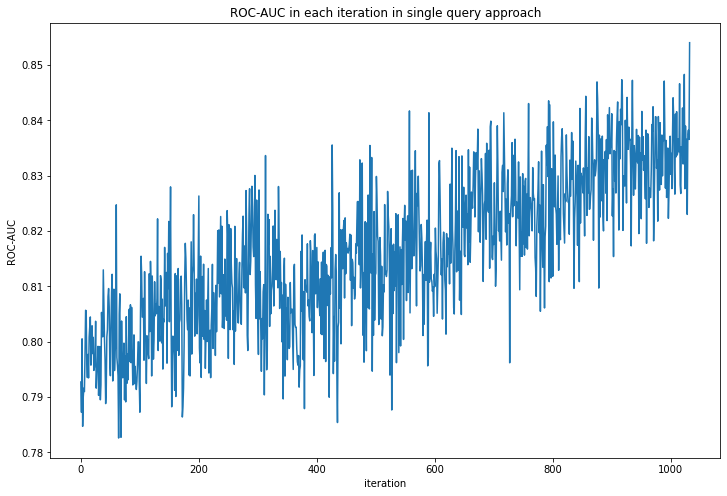

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.lineplot(y= single_query_auc_scores, x=range(len(single_query_auc_scores)))
plt.title('ROC-AUC in each iteration in single query approach')
plt.xlabel('iteration')
plt.ylabel('ROC-AUC')

Combaring with the same number of randomly choosen samples

In [ ]:
simulatedX = pool_df.sample(n=len(single_query_auc_scores)-1, random_state=random_seed)
simulatedX_final =pd.concat([simulatedX, pd.concat([pd.DataFrame(X_init_train), pd.DataFrame(y_init_train)],axis=1)])

In [ ]:
sim_rfc = RandomForestClassifier(class_weight='balanced', random_state=random_seed)
sim_rfc.fit(simulatedX_final.drop(columns=['ACTIVITY']), simulatedX_final['ACTIVITY'])
roc_auc_score(y_val, sim_rfc.predict_proba(X_val)[:, 1])

0.8199919996444287

### Batch query approach

In [ ]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

BATCH_SIZE = 10
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)


learner = ActiveLearner(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=random_seed),
    query_strategy=preset_batch,
    X_training=pd.DataFrame(X_init_train).to_numpy(), y_training=y_init_train.to_numpy()
    
)

In [ ]:
# Pool of unlabeled samples
pool_df = train_df.drop(index=labeled_df.index)

# List o scores
auc_scores = [roc_auc_score(y_val, learner.predict_proba(X_val.to_numpy())[:, 1])]

# List of queries
queries = []

for i in range(int(max_queries/BATCH_SIZE)):
    # Query 
    query_idx, query_inst = learner.query(pool_df.drop(columns=['ACTIVITY']).to_numpy())
    # Retrain model with updated labels 
    learner.teach(query_inst, pool_df['ACTIVITY'].iloc[query_idx].to_numpy())
    # Add index to queries
    queries.extend(list(pool_df.iloc[query_idx].index))
    # Removed query from pool 
    pool_df = pool_df.drop(index=pool_df.iloc[query_idx].index)
    # Add new score to score list
    auc_scores.append(roc_auc_score(y_val.to_numpy(), learner.predict_proba(X_val.to_numpy())[:, 1]))
    print(f'Iteration: {i} Added sample:{queries[-1]} AUC: {auc_scores[-1]}')

    if auc_scores[-1] >= auc_tresh:
        print(f'Acieved target AUC:{auc_scores[-1]}')
        break

Iteration: 0 Added sample:5082 AUC: 0.796968754166852
Iteration: 1 Added sample:7531 AUC: 0.784323747722121
Iteration: 2 Added sample:12086 AUC: 0.7909240410684921
Iteration: 3 Added sample:169 AUC: 0.7818347482110316
Iteration: 4 Added sample:8390 AUC: 0.7964353971287612
Iteration: 5 Added sample:8165 AUC: 0.8040579581314725
Iteration: 6 Added sample:5870 AUC: 0.7908129250188898
Iteration: 7 Added sample:2730 AUC: 0.7953909062625005
Iteration: 8 Added sample:3262 AUC: 0.7930796924307746
Iteration: 9 Added sample:4015 AUC: 0.8080359127072314
Iteration: 10 Added sample:11779 AUC: 0.7916129605760256
Iteration: 11 Added sample:9879 AUC: 0.8123694386417174
Iteration: 12 Added sample:3489 AUC: 0.8091470732032534
Iteration: 13 Added sample:6016 AUC: 0.812702786790524
Iteration: 14 Added sample:10639 AUC: 0.8097470998711054
Iteration: 15 Added sample:12226 AUC: 0.8193697497666563
Iteration: 16 Added sample:5961 AUC: 0.8062358327036757
Iteration: 17 Added sample:8089 AUC: 0.7983021467620783
It

In [ ]:
batch_query_auc_scores = auc_scores.copy()
batch_query_queries = queries.copy()

Text(0, 0.5, 'ROC-AUC')

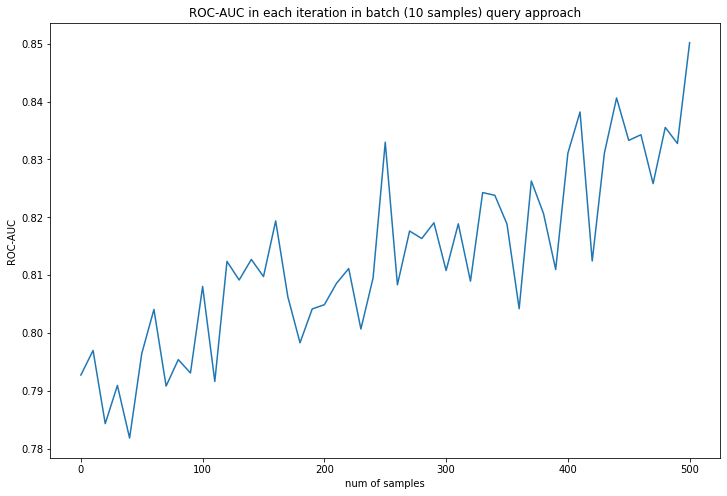

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.lineplot(y= batch_query_auc_scores, x=range(0,len(batch_query_auc_scores)*BATCH_SIZE, 10))
plt.title('ROC-AUC in each iteration in batch (10 samples) query approach')
plt.xlabel('num of samples')
plt.ylabel('ROC-AUC')

In [ ]:
simulatedX = pool_df.sample(n=(len(batch_query_auc_scores)-1)*BATCH_SIZE, random_state=random_seed)
simulatedX_final =pd.concat([simulatedX, pd.concat([pd.DataFrame(X_init_train), pd.DataFrame(y_init_train)],axis=1)])

In [ ]:
sim_rfc = RandomForestClassifier(class_weight='balanced', random_state=random_seed)
sim_rfc.fit(simulatedX_final.drop(columns=['ACTIVITY']), simulatedX_final['ACTIVITY'])
roc_auc_score(y_val, sim_rfc.predict_proba(X_val)[:, 1])

0.8076358949286634

### Batch query approach initial feature selection

In [ ]:
# Creates a BorutaShap selector for classification
selector = BorutaShap(model=RandomForestClassifier(class_weight='balanced', random_state=random_seed),
                      importance_measure='shap',
                      classification=True)

# Fits the selector
selector.fit(X = pd.DataFrame(X_init_train),
            y = y_init_train.to_numpy(),
            n_trials = 100,
            sample = False,
            verbose = True)


# Display features to be removed
features_to_remove = selector.features_to_remove

# # Train set which will be extended in active learning loop
# X_train = X_init_train.copy()
# y_train = y_init_train.copy()

# Removes them
X_train_boruta_shap = pd.DataFrame(X_init_train).drop(columns = features_to_remove)
X_val_boruta_shap =  pd.DataFrame(X_val).drop(columns = features_to_remove)


  0%|          | 0/100 [00:00<?, ?it/s]

17 attributes confirmed important: ['SlogP_VSA2', 'VSA_EState2', 'VSA_EState5', 'FilterItLogS', 'SLogP', 'TopoPSA(NO)', 'JGI6', 'TopoPSA', 'NdssC', 'AATSC5p', 'ATSC5m', 'VSA_EState3', 'EState_VSA4', 'GATS5m', 'SaasC', 'AATSC5m', 'EState_VSA2']
414 attributes confirmed unimportant: ['PEOE_VSA6', 'ATSC0m', 'MATS1pe', 'nCl', 'GGI5', 'ATSC7v', 'GGI3', 'nFAHRing', 'nHetero', 'ATSC8d', 'AATS2m', 'AATSC5pe', 'GATS3pe', 'PEOE_VSA8', 'ATSC4d', 'C2SP2', 'JGI5', 'n8FaRing', 'AXp-1d', 'NdsCH', 'ATSC5pe', 'AATSC4v', 'n7aRing', 'ATS0dv', 'n5Ring', 'NtsC', 'ATSC2i', 'GATS4m', 'MATS1se', 'SlogP_VSA5', 'AATS0pe', 'AATS4v', 'NssssN', 'ATSC6dv', 'GATS3m', 'PEOE_VSA12', 'ATSC8dv', 'NaaaC', 'NssCH2', 'NdS', 'GATS1d', 'ZMIC2', 'nHRing', 'ATSC6i', 'n10Ring', 'ATSC2d', 'JGT10', 'GATS4p', 'ATSC7d', 'NaaSe', 'Xch-7d', 'AATS2p', 'GGI4', 'AATS4i', 'SaaaC', 'NdNH', 'AATSC4p', 'GATS1i', 'SMR_VSA7', 'ZMIC1', 'PEOE_VSA13', 'AATS4d', 'AATS1p', 'AATS5pe', 'ATSC2p', 'SMR_VSA6', 'nAHRing', 'AATSC0m', 'AXp-3dv', 'EState_V

In [ ]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

BATCH_SIZE = 10
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)


learner = ActiveLearner(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=random_seed),
    query_strategy=preset_batch,
    X_training=pd.DataFrame(X_train_boruta_shap).to_numpy(), y_training=y_init_train.to_numpy()
    
)

In [ ]:
# Pool of unlabeled samples
pool_df = train_df.drop(columns = features_to_remove, index=labeled_df.index)

# List o scores
auc_scores = [roc_auc_score(y_val, learner.predict_proba(X_val_boruta_shap.to_numpy())[:, 1])]

# List of queries
queries = []

for i in range(int(max_queries/BATCH_SIZE)):
    # Query 
    query_idx, query_inst = learner.query(pool_df.drop(columns=['ACTIVITY']).to_numpy())
    # Retrain model with updated labels 
    learner.teach(query_inst, pool_df['ACTIVITY'].iloc[query_idx].to_numpy())
    # Add index to queries
    queries.extend(list(pool_df.iloc[query_idx].index))
    # Removed query from pool 
    pool_df = pool_df.drop(index=pool_df.iloc[query_idx].index)
    # Add new score to score list
    auc_scores.append(roc_auc_score(y_val.to_numpy(), learner.predict_proba(X_val_boruta_shap.to_numpy())[:, 1]))
    print(f'Iteration: {i} Added sample:{queries[-1]} AUC: {auc_scores[-1]}')

    if auc_scores[-1] >= auc_tresh:
        print(f'Acieved target AUC:{auc_scores[-1]}')
        break

### Batch query approach full feature selection

In [ ]:
# Creates a BorutaShap selector for classification
selector = BorutaShap(model=RandomForestClassifier(class_weight='balanced', random_state=random_seed),
                      importance_measure='shap',
                      classification=True)

# Fits the selector
selector.fit(X = pd.DataFrame(X_init_train),
            y = y_init_train.to_numpy(),
            n_trials = 50,
            sample = False,
            verbose = True)


# Display features to be removed
features_to_remove = selector.features_to_remove

# Train set which will be extended in active learning loop
X_train = X_init_train.copy()
y_train = y_init_train.copy()

# Removes them
X_train_boruta_shap = pd.DataFrame(X_train).drop(columns = features_to_remove)
X_val_boruta_shap =  pd.DataFrame(X_val).drop(columns = features_to_remove)


  0%|          | 0/50 [00:00<?, ?it/s]

14 attributes confirmed important: ['SlogP_VSA2', 'VSA_EState2', 'VSA_EState5', 'FilterItLogS', 'SLogP', 'TopoPSA(NO)', 'JGI6', 'TopoPSA', 'NdssC', 'AATSC5p', 'VSA_EState3', 'EState_VSA4', 'SaasC', 'EState_VSA2']
412 attributes confirmed unimportant: ['PEOE_VSA6', 'ATSC0m', 'nCl', 'GGI5', 'ATSC7v', 'GGI3', 'nFAHRing', 'nHetero', 'ATSC8d', 'AATS2m', 'AATSC5pe', 'GATS3pe', 'PEOE_VSA8', 'ATSC4d', 'C2SP2', 'JGI5', 'n8FaRing', 'AXp-1d', 'NdsCH', 'ATSC5pe', 'AATSC4v', 'n7aRing', 'ATS0dv', 'n5Ring', 'NtsC', 'ATSC2i', 'GATS4m', 'MATS1se', 'SlogP_VSA5', 'AATS0pe', 'AATS4v', 'NssssN', 'ATSC6dv', 'GATS3m', 'PEOE_VSA12', 'ATSC8dv', 'NaaaC', 'NssCH2', 'NdS', 'GATS1d', 'ZMIC2', 'nHRing', 'ATSC6i', 'n10Ring', 'ATSC2d', 'JGT10', 'GATS4p', 'ATSC7d', 'NaaSe', 'Xch-7d', 'AATS2p', 'GGI4', 'AATS4i', 'SaaaC', 'NdNH', 'AATSC4p', 'GATS1i', 'SMR_VSA7', 'ZMIC1', 'PEOE_VSA13', 'AATS4d', 'AATS1p', 'AATS5pe', 'ATSC2p', 'SMR_VSA6', 'nAHRing', 'AATSC0m', 'AXp-3dv', 'EState_VSA5', 'n6FRing', 'PEOE_VSA11', 'n9FaRing',

In [ ]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

BATCH_SIZE = 10
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)


learner = ActiveLearner(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=random_seed),
    query_strategy=preset_batch,
    X_training=pd.DataFrame(X_train_boruta_shap).to_numpy(), y_training=y_train.to_numpy()
    
)

In [ ]:
# Pool of unlabeled samples
pool_df = train_df.drop(index=labeled_df.index)

# List o scores
auc_scores = [roc_auc_score(y_val, learner.predict_proba(X_val_boruta_shap.to_numpy())[:, 1])]

# List of queries
queries = []


for i in range(int(max_queries/BATCH_SIZE)):

    # Query 
    query_idx, query_inst = learner.query(pool_df.drop(columns=features_to_remove).drop(columns=['ACTIVITY']).to_numpy())

    # Index to add for training
    X_train = pd.concat([X_train, pool_df.drop(columns=['ACTIVITY']).iloc[query_idx]])
    y_train = pd.concat([y_train, pool_df['ACTIVITY'].iloc[query_idx]])


    # Creates a BorutaShap selector for classification
    selector = BorutaShap(model=RandomForestClassifier(class_weight='balanced', random_state=random_seed),
                          importance_measure='shap',
                          classification=True)

    # Fits the selector
    selector.fit(X = pd.DataFrame(X_train),
                y = y_train.to_numpy(),
                n_trials = 50,
                sample = False,
                verbose = True)
    
    # Display features to be removed
    features_to_remove = selector.features_to_remove

    # Removes them
    X_train_boruta_shap = pd.DataFrame(X_train).drop(columns = features_to_remove)
    X_val_boruta_shap =  pd.DataFrame(X_val).drop(columns = features_to_remove)

    learner = ActiveLearner(
        estimator=RandomForestClassifier(class_weight='balanced', random_state=random_seed),
        query_strategy=preset_batch,
        X_training=pd.DataFrame(X_train_boruta_shap).to_numpy(), y_training=y_train.to_numpy()
        
    )

    # Add index to queries
    queries.extend(list(pool_df.iloc[query_idx].index))

    # Removed query from pool 
    pool_df = pool_df.drop(index=pool_df.iloc[query_idx].index)

    # Add new score to score list
    auc_scores.append(roc_auc_score(y_val.to_numpy(), learner.predict_proba(X_val_boruta_shap.to_numpy())[:, 1]))
    print(f'Iteration: {i} Added sample:{queries[-1]} AUC: {auc_scores[-1]}')

    if auc_scores[-1] >= auc_tresh:
        print(f'Acieved target AUC:{auc_scores[-1]}')
        break

### Conclusions

Single and batch query methods were evaluated. Batch approach turned out to be more efficient (in terms of ROC-AUC) and probably better in real world scenario where samples are labeled by domain experts. 

## Evaluation

Evaluation of batch query approach

In [ ]:
pool_df = train_df.drop(index=labeled_df.index)
train_batch_X = pd.concat([pd.concat([pd.DataFrame(X_init_train), pd.DataFrame(y_init_train)],axis=1), pool_df.loc[batch_query_queries]])

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=random_seed)
rfc.fit(train_batch_X.drop(columns=['ACTIVITY']), train_batch_X['ACTIVITY'])
roc_auc_score(y_val, rfc.predict_proba(X_val)[:, 1])

0.8501711187163874

### Results on test sets

In [ ]:
print('For Testset I:')
evaluate_model(test_I_df['ACTIVITY'],
               rfc.predict(test_I_df.drop(columns=['ACTIVITY'])),
               rfc.predict_proba(test_I_df.drop(columns=['ACTIVITY']))[:, 1])

print('\nFor Testset II:')
evaluate_model(test_II_df['ACTIVITY'],
               rfc.predict(test_II_df.drop(columns=['ACTIVITY'])),
               rfc.predict_proba(test_II_df.drop(columns=['ACTIVITY']))[:, 1])

print('\nFor Testset III:')
evaluate_model(test_III_df['ACTIVITY'],
               rfc.predict(test_III_df.drop(columns=['ACTIVITY'])),
               rfc.predict_proba(test_III_df.drop(columns=['ACTIVITY']))[:, 1])


For Testset I:
Accuracy:0.7045454545454546
B-Accuracy:0.6880952380952381
F1:0.7719298245614035
Precision:0.8148148148148148
Recall:0.7333333333333333
ROC-AUC:0.780952380952381
Average precision:0.8813100350163346

For Testset II:
Accuracy:0.6341463414634146
B-Accuracy:0.6636363636363636
F1:0.5161290322580645
Precision:0.4
Recall:0.7272727272727273
ROC-AUC:0.7287878787878789
Average precision:0.4747097599370327

For Testset III:
Accuracy:0.6982408660351827
B-Accuracy:0.7158740091781394
F1:0.18315018315018314
Precision:0.10460251046025104
Recall:0.7352941176470589
ROC-AUC:0.7911347517730496
Average precision:0.2188365302700726


The results look reasonable especially if you consider use of < 12% of the dataset

### Feature selection

Let's perform feature selection using BorutaShap package

In [ ]:
from BorutaShap import BorutaShap

# Creates a BorutaShap selector for classification
selector = BorutaShap(model=RandomForestClassifier(class_weight='balanced', random_state=random_seed),
                      importance_measure='shap',
                      classification=True)

# Fits the selector
selector.fit(X = train_batch_X.drop(columns=['ACTIVITY']),
            y = train_batch_X['ACTIVITY'].to_numpy(),
            n_trials = 50,
            sample = False,
            verbose = True)


# Display features to be removed
features_to_remove = selector.features_to_remove

  0%|          | 0/50 [00:00<?, ?it/s]

12 attributes confirmed important: ['SLogP', 'TopoPSA(NO)', 'SssCH2', 'MATS1pe', 'TopoPSA', 'JGI2', 'FilterItLogS', 'AATSC0v', 'SMR_VSA7', 'SaasC', 'SIC1', 'VSA_EState2']
417 attributes confirmed unimportant: ['MATS1d', 'MATS3pe', 'GATS3v', 'AATSC5v', 'GATS3pe', 'nFARing', 'NdNH', 'ATSC6d', 'SlogP_VSA1', 'BertzCT', 'SIC2', 'ATSC1m', 'AATSC4i', 'ATSC1dv', 'GATS4p', 'ATSC2i', 'AATSC5d', 'GATS1dv', 'ATSC4i', 'ATSC6v', 'Xch-6d', 'EState_VSA7', 'NdO', 'TopoShapeIndex', 'nCl', 'GATS1se', 'n6AHRing', 'GGI3', 'Xc-6dv', 'n7FHRing', 'C1SP3', 'NdS', 'ATSC1i', 'ATSC5dv', 'NssNH', 'n3HRing', 'n8Ring', 'GGI10', 'NaasN', 'ATSC5v', 'n6aRing', 'PEOE_VSA2', 'AATS0i', 'GATS5dv', 'SssssC', 'n6FRing', 'AATS5d', 'IC2', 'n9FARing', 'ATSC2pe', 'ATSC3p', 'GATS1pe', 'AATS3d', 'C4SP3', 'GGI6', 'ATS1dv', 'n7FRing', 'n6aHRing', 'naHRing', 'ZMIC3', 'fragCpx', 'MATS5m', 'AATSC5p', 'nFAHRing', 'JGI4', 'JGI9', 'JGI5', 'nBridgehead', 'ATSC4m', 'NdsCH', 'ATSC0d', 'ATSC4p', 'CIC0', 'AATSC0m', 'Xc-6d', 'MATS4i', 'AATS3dv'

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=random_seed)
rfc.fit(train_batch_X.drop(columns=['ACTIVITY']).drop(columns=features_to_remove), train_batch_X['ACTIVITY'])
roc_auc_score(y_val, rfc.predict_proba(X_val.drop(columns=features_to_remove))[:, 1])

0.8048357704786879

In [ ]:
print('For Testset I:')
evaluate_model(test_I_df['ACTIVITY'],
               rfc.predict(test_I_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove)),
               rfc.predict_proba(test_I_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove))[:, 1])

print('\nFor Testset II:')
evaluate_model(test_II_df['ACTIVITY'],
               rfc.predict(test_II_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove)),
               rfc.predict_proba(test_II_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove))[:, 1])

print('\nFor Testset III:')
evaluate_model(test_III_df['ACTIVITY'],
               rfc.predict(test_III_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove)),
               rfc.predict_proba(test_III_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove))[:, 1])

For Testset I:
Accuracy:0.7272727272727273
B-Accuracy:0.7428571428571429
F1:0.7777777777777777
Precision:0.875
Recall:0.7
ROC-AUC:0.7404761904761905
Average precision:0.8636317680512124

For Testset II:
Accuracy:0.6829268292682927
B-Accuracy:0.7545454545454545
F1:0.6060606060606061
Precision:0.45454545454545453
Recall:0.9090909090909091
ROC-AUC:0.7954545454545454
Average precision:0.5661651356773307

For Testset III:
Accuracy:0.6617050067658998
B-Accuracy:0.7247183979974968
F1:0.17763157894736842
Precision:0.1
Recall:0.7941176470588235
ROC-AUC:0.7779724655819774
Average precision:0.20163886312642676


There is no clear answer which model is better. Model with selected features has only 22 features but worse performance on validation set and `test_set_I`, `test_set_III`. The choice of model will depend on business priorities.



### Feature importance

Let's check feature importance of a model

In [ ]:
pool_df = train_df.drop(index=labeled_df.index)
train_batch_X = pd.concat([pd.concat([pd.DataFrame(X_init_train), pd.DataFrame(y_init_train)],axis=1), pool_df.loc[batch_query_queries]])

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=random_seed)
rfc.fit(train_batch_X.drop(columns=['ACTIVITY']), train_batch_X['ACTIVITY'])
roc_auc_score(y_val, rfc.predict_proba(X_val)[:, 1])

0.8501711187163874

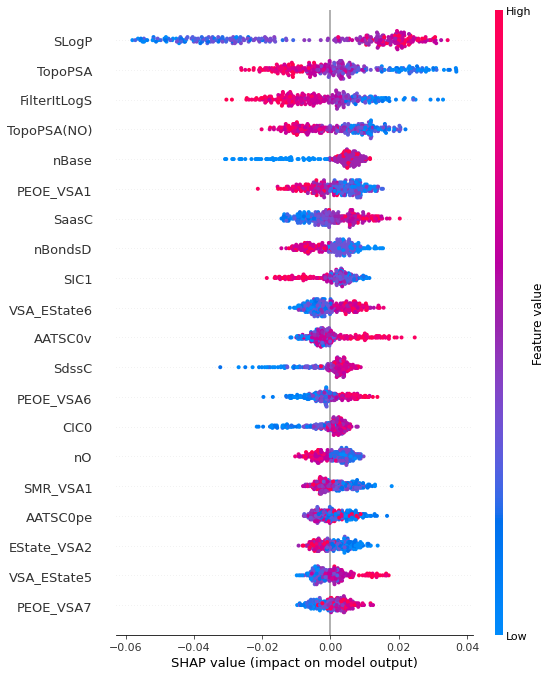

In [ ]:
import shap

explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_val)[1]

shap.summary_plot(shap_values, X_val)


Most of important features in model, was also considere as important in feature selection step, but there are some features like `nBase` that was not selected as important but has significant influence on final model.

I decided to deploy model with higer dimensionality.

In [ ]:
pool_df = train_df.drop(index=labeled_df.index)
train_batch_X_full = pd.concat([labeled_df, pool_df.loc[batch_query_queries]])

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=random_seed)
rfc.fit(train_batch_X_full.drop(columns=['ACTIVITY']), train_batch_X_full['ACTIVITY'])


RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
print('For Testset I:')
evaluate_model(test_I_df['ACTIVITY'],
               rfc.predict(test_I_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove)),
               rfc.predict_proba(test_I_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove))[:, 1])

print('\nFor Testset II:')
evaluate_model(test_II_df['ACTIVITY'],
               rfc.predict(test_II_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove)),
               rfc.predict_proba(test_II_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove))[:, 1])

print('\nFor Testset III:')
evaluate_model(test_III_df['ACTIVITY'],
               rfc.predict(test_III_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove)),
               rfc.predict_proba(test_III_df.drop(columns=['ACTIVITY']).drop(columns=features_to_remove))[:, 1])

For Testset I:


The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- AATS0d
- AATS0i
- AATS0m
- AATS0p
- AATS0pe
- ...



ValueError: ignored

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAtom,nSpiro,nBridgehead,nHetero,nH,...,JGI7,JGI8,JGI9,JGI10,JGT10,TopoShapeIndex,SRW05,TSRW10,WPath,ACTIVITY
107,25.869242,18.442145,0.0,2.0,12.0,62.0,0.0,2.0,9.0,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
556,33.332329,24.530728,0.0,0.0,18.0,66.0,2.0,0.0,12.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10501,30.327461,23.147331,0.0,1.0,16.0,72.0,1.0,0.0,7.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3614,20.155669,15.780409,0.0,1.0,11.0,55.0,0.0,0.0,7.0,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
923,31.542166,24.258516,0.0,1.0,30.0,63.0,0.0,0.0,12.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.007552,0.008908,0.009312,0.005594,0.412919,0.900000,3.044522,87.307466,4460.0,1.0
10279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.015005,0.011293,0.008375,0.004314,0.453766,0.900000,0.000000,64.079218,2778.0,1.0
7678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.012379,0.008280,0.006375,0.006490,0.384118,0.888889,2.397895,80.900689,3071.0,1.0
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.022046,0.011267,0.016139,0.006310,0.586466,0.857143,2.397895,72.829728,1378.0,1.0
